## RL modelling 

We have 2 type of files for each state one csv containing all the clandestine graves by state visibility level and distance to closest city and the other as a geojson with Mexico's delimitation of states

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Polygon
import numpy as np
import seaborn as sns
import time
from IPython.display import Image
from numpy import unravel_index

In [6]:
states = ["sinaloa","michoacan","guerrero","veracruz"]
df_state = []
for state in states:
    filename= "data/"+state+".csv"
    df = gpd.read_file(filename)
    df_state.append(df)

In [7]:
df_state[3].head()

,system:index,TiempoViaje,Visibilidad,layer,.geo,geometry
0,0_0,4.054536987229765,3.0,Puntos de Hallazgo,"{""type"":""Point"",""coordinates"":[-97.52461119812...",None
1,0_1,35.94113854996112,0.0,Puntos de Hallazgo,"{""type"":""Point"",""coordinates"":[-96.33708124197...",None
2,0_2,8.526271043810116,6.0,Puntos de Hallazgo,"{""type"":""Point"",""coordinates"":[-96.85377957654...",None
3,0_3,1.166997347753456,2.0,Puntos de Hallazgo,"{""type"":""Point"",""coordinates"":[-96.73261242361...",None
4,0_4,28.38684297771805,30.0,Puntos de Hallazgo,"{""type"":""Point"",""coordinates"":[-96.68988085822...",None


In [8]:
for i in range(len(df_state)):
    df_state[i] = df_state[i].rename(columns={"TiempoViaje": "transportation_time", "Visibilidad": "visibility"})
    df_state[i] = df_state[i].drop(['system:index', 'layer'], axis=1)
df_state[3].head()

,transportation_time,visibility,.geo,geometry
0,4.054536987229765,3.0,"{""type"":""Point"",""coordinates"":[-97.52461119812...",None
1,35.94113854996112,0.0,"{""type"":""Point"",""coordinates"":[-96.33708124197...",None
2,8.526271043810116,6.0,"{""type"":""Point"",""coordinates"":[-96.85377957654...",None
3,1.166997347753456,2.0,"{""type"":""Point"",""coordinates"":[-96.73261242361...",None
4,28.38684297771805,30.0,"{""type"":""Point"",""coordinates"":[-96.68988085822...",None


Obtaining clandestine graves information for all the country

In [9]:
country_cg = gpd.read_file("C:\\repos\\591\\project\\data\\todos.geojson")
country_cg.head(1)

,id,TiempoViaje,Visibilidad,layer,geometry
0,0_0,0.869318,12.48,Puntos de Hallazgo,POINT (-110.98195 31.30222)


Obtaining geo points for all Mexico

In [10]:
req_dc = requests.get('https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson')
json_dc = req_dc.json()

geo_df = gpd.GeoDataFrame.from_features((json_dc))
geo_df.drop(columns=["id"])
geo_df.head()

,geometry,id,state_code,state_name
0,"POLYGON ((-99.09052 19.50926, -99.06421 19.498...",None,9,Distrito Federal
1,"POLYGON ((-100.53878 18.84399, -100.50201 18.8...",None,12,Guerrero
2,"POLYGON ((-99.85919 20.26838, -99.85950 20.264...",None,15,México
3,"POLYGON ((-99.06199 19.04877, -99.02935 19.085...",None,17,Morelos
4,"POLYGON ((-108.47046 27.03457, -108.42165 27.0...",None,25,Sinaloa


<Figure size 640x480 with 0 Axes>

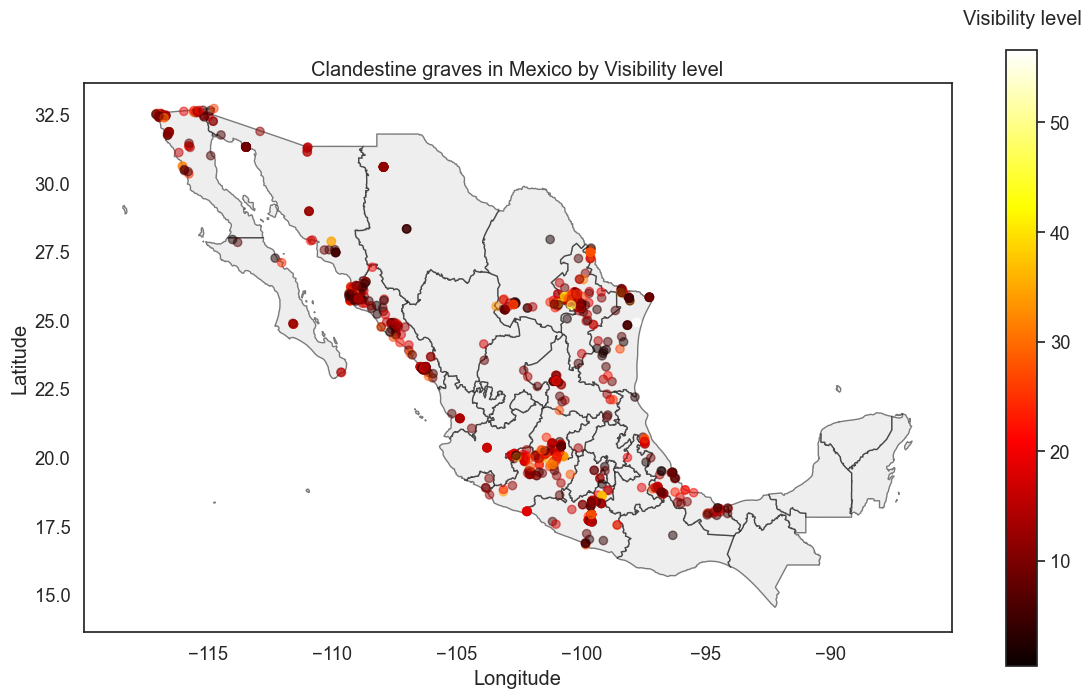

In [11]:
sns.set_style("white")
sns.despine(left=True, bottom=True)
sns.set_context("notebook", font_scale=1.2)

ax = geo_df.plot(color='#e0dfde', edgecolor='black', figsize=(14,8), alpha=.5)

data = country_cg[['geometry', 'Visibilidad']]
heat = data.plot(column='Visibilidad', cmap='hot', legend=True, ax=ax, alpha=0.5)

ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Clandestine graves in Mexico by Visibility level')
plt.text(1.15, 1.135, 'Visibility level', ha='right', va='top', transform=ax.transAxes)
plt.show()

Generating grid space

In [12]:
def create_grid(poly, n_rows, n_cols):
    """
    Creates a grid of squares with equal area inside a polygon.
    A geopandas GeoDataFrame with n_rows * n_cols squares inside the given polygon. 
    """
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = poly.bounds
    
    wide = (maxx - minx) / float(n_cols)
    length = (maxy - miny) / float(n_rows)

    # Create a list of cells for the grid
    cols = list(np.arange(minx, maxx + wide, wide))
    rows = list(np.arange(miny, maxy + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

    grid = gpd.GeoDataFrame({'geometry':polygons})

    return grid
geo_slice = geo_df.query("state_name == 'Veracruz de Ignacio de la Llave'")
grid_full = create_grid(geo_df["geometry"][25], 20,20)
print(grid_full.head(1))


                                            geometry
0  POLYGON ((-98.68194 17.13680, -98.42825 17.136...


[Text(0.5, 51.249999999999986, 'Longitude'),
 Text(77.60244867517528, 0.5, 'Latitude'),
 Text(0.5, 1.0, 'Veracruz')]

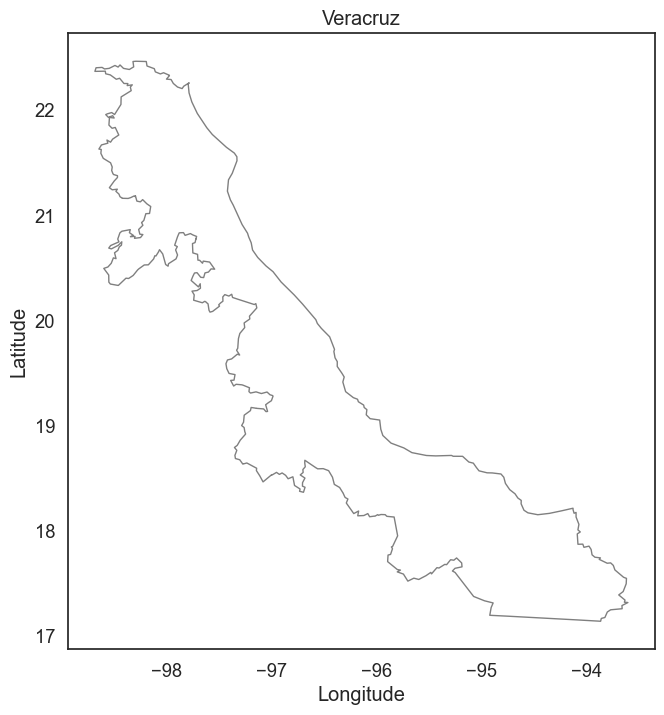

In [13]:
# show slice of only one state
ax = geo_slice.plot(color='none', edgecolor='black',figsize=(8,8), alpha=0.5)
ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz')


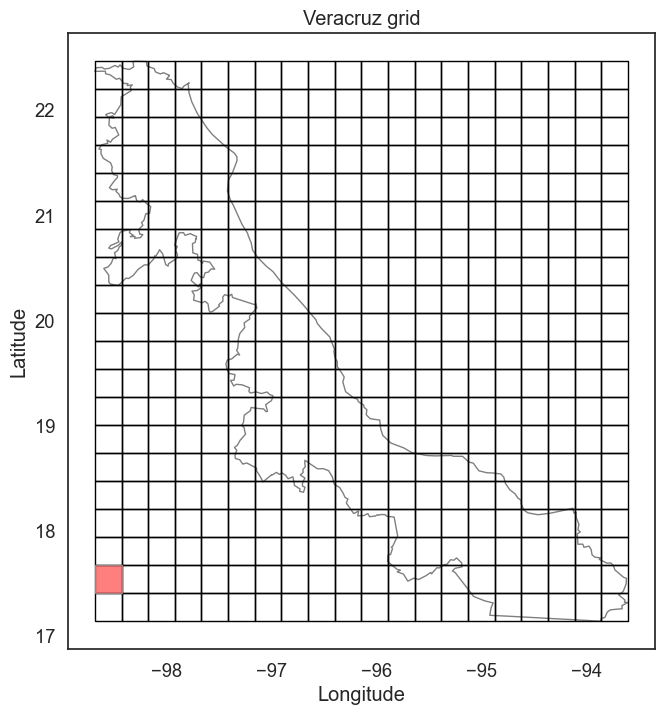

In [14]:
#obtaining only one cell
cell = grid_full.iloc[1]
cell_geom = cell.geometry
cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom])

ax = geo_slice.plot(color='none', edgecolor='black',figsize=(8,8), alpha=0.5)
grid_full.plot(ax=ax, color='none', edgecolor='black')
cell_gdf.plot(ax=ax, color='red', alpha=0.5)
ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz grid')

plt.show()

This will be the full grid of the environment but we want to show only the grid where the agent can "circulate"

In [15]:
def create_close_grid(poly, n_rows, n_cols):
    # Get the exterior ring of the polygon
    ext_ring = poly.exterior

    # Calculate the width and height of each cell
    width = ext_ring.length / float(n_cols)
    height = poly.area / (width * float(n_rows))

    polygons = []
    for j in range(n_rows):
        for i in range(n_cols):
            # Calculate the vertices of the cell
            x_min = ext_ring.bounds[0] + i * width
            y_min = ext_ring.bounds[1] + j * height
            x_max = x_min + width
            y_max = y_min + height
            vertices = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]

            # Create the cell polygon and add it to the list
            cell_poly = Polygon(vertices)
            if cell_poly.intersects(poly):
                polygons.append(cell_poly)
            # Create a GeoDataFrame from the polygons
    grid = gpd.GeoDataFrame({'geometry': polygons})

    return grid
grid = create_close_grid(geo_df["geometry"][25], 100,100)

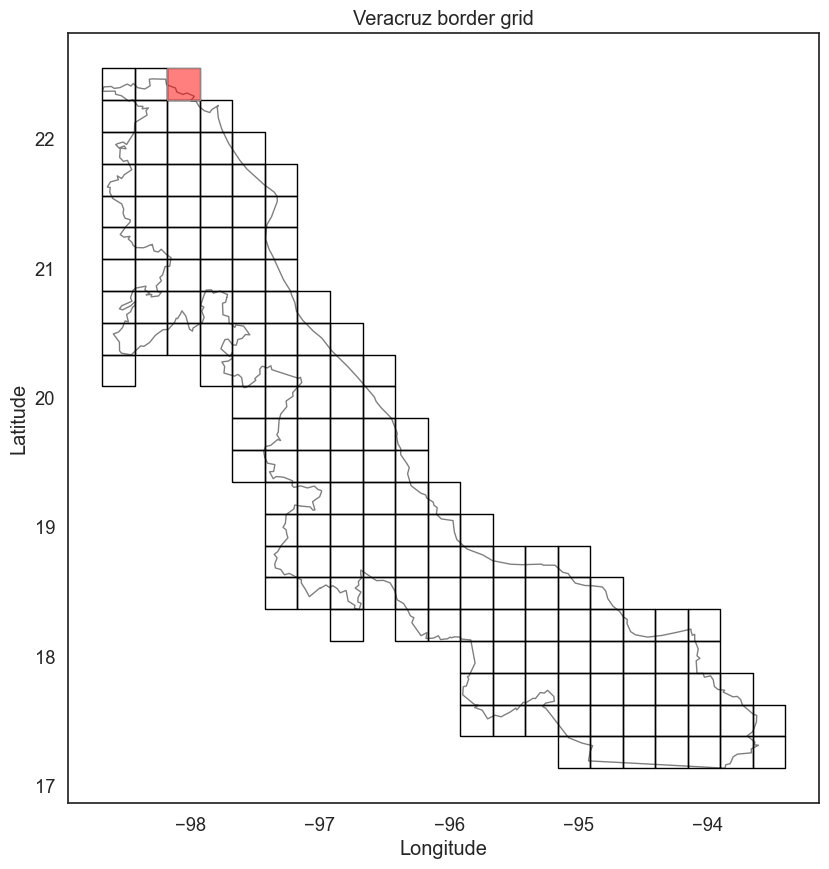

In [16]:
n_rows = 1
n_cols = 1
cell = grid.iloc[(n_rows - 3 - 1) * n_cols + 2]['geometry']
cell_geom = cell
cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom])

geo_slice = geo_df.query("state_name == 'Veracruz de Ignacio de la Llave'")
ax = geo_slice.plot(color='none', edgecolor='black',figsize=(10,10), alpha=0.5)
grid.plot(ax=ax, color='none', edgecolor='black')
cell_gdf.plot(ax=ax, color='red', alpha=0.5)
ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz border grid')

plt.show()

### Rewards

In [17]:
veracruz_meta = gpd.read_file("C:\\repos\\591\\project\\data\\veracruz.geojson")
veracruz_meta.head(3)

,id,TiempoViaje,Visibilidad,layer,geometry
0,0_0,4.054537,6.26,Puntos de Hallazgo,POINT (-97.52461 20.73558)
1,0_1,35.941139,5.10,Puntos de Hallazgo,POINT (-96.33708 19.45803)
2,0_2,8.526271,12.55,Puntos de Hallazgo,POINT (-96.85378 19.36461)


In [18]:
sina_meta = gpd.read_file("C:\\repos\\591\\project\\data\\sinaloa.geojson")
sina_meta.head(3)

,id,TiempoViaje,Visibilidad,layer,geometry
0,0_0,9.270390,8.0,Puntos de Hallazgo,POINT (-106.35120 23.18333)
1,0_1,83.376808,0.0,Puntos de Hallazgo,POINT (-109.28108 25.70714)
2,0_2,14.321184,0.0,Puntos de Hallazgo,POINT (-107.62645 24.88558)


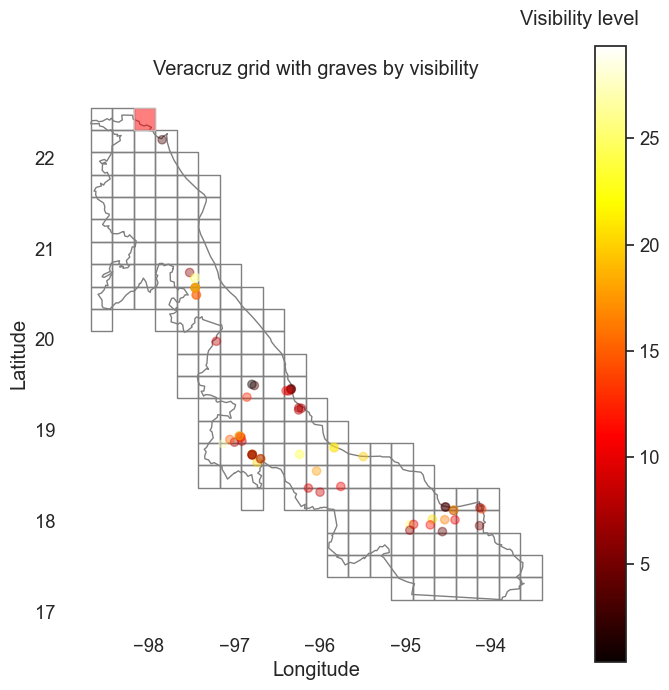

In [19]:

cell = grid.iloc[(n_rows - 3 - 1) * n_cols + 2]['geometry']
cell_geom = cell
cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom])

ax = geo_slice.plot(color='none', edgecolor='black', figsize=(8,8), alpha=0.5)

sns.set_style("white")
sns.despine(left=True, bottom=True)
sns.set_context("notebook", font_scale=1.2)

grid.plot(ax=ax, color='none', edgecolor='grey')
cell_gdf.plot(ax=ax, color='red', alpha=0.5)

data = veracruz_meta[['geometry', 'Visibilidad']]
data.plot(column='Visibilidad', cmap='hot', legend=True, ax=ax, alpha=0.4)

ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz grid with graves by visibility')
plt.text(1.15, 1.135, 'Visibility level', ha='right', va='top', transform=ax.transAxes)

plt.show()

Calculating rewards

In [155]:
def calculate_rewards(df):
    df["TiempoViaje"] = df["TiempoViaje"].astype(float)
    df["Visibilidad"] = df["Visibilidad"].astype(float)
    rewards = df["TiempoViaje"] + df["Visibilidad"]

    max_value = rewards.max()
    min_value = rewards.min()
    x = []

    for i in rewards:
        y = ((i - min_value) / (max_value - min_value))
        if y == 0:
            x.append(0)
        else:
            x.append((1/((i - min_value) / (max_value - min_value)))*10)
    
    max_value = max(x)
    min_value = min(x)

    #return [((i - min_value) / (max_value - min_value))*100 for i in x]
    #return rewards
    return [(1/i)*100 for i in rewards]

veracruz_meta = veracruz_meta.fillna(0)
veracruz_meta["rewards"] = calculate_rewards(veracruz_meta)
veracruz_meta.head(1)


,id,TiempoViaje,Visibilidad,layer,geometry,rewards
0,0_0,4.054537,6.26,Puntos de Hallazgo,POINT (-97.52461 20.73558),9.695054


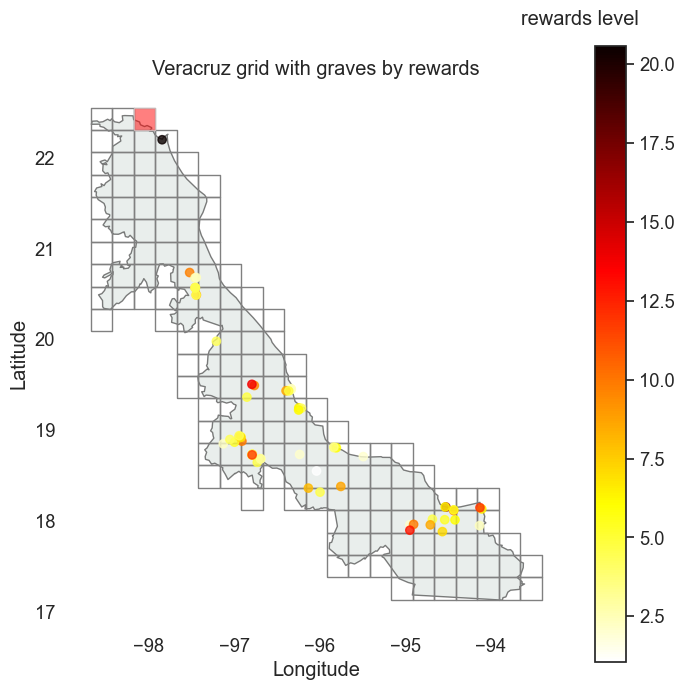

In [156]:
import seaborn as sns

cell = grid.iloc[(n_rows - 3 - 1) * n_cols + 2]['geometry']
cell_geom = cell
cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom])

ax = geo_slice.plot(color='#d5deda', edgecolor='black', figsize=(8,8), alpha=.5)

sns.set_style("white")
sns.despine(left=True, bottom=True)
sns.set_context("notebook", font_scale=1.2)

grid.plot(ax=ax, color='none', edgecolor='grey')
cell_gdf.plot(ax=ax, color='red', alpha=0.5)

data = veracruz_meta[['geometry', 'rewards']]
data.plot(column='rewards', cmap='hot_r', legend=True, ax=ax, alpha=0.8)

ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz grid with graves by rewards')
plt.text(1.15, 1.135, 'rewards level', ha='right', va='top', transform=ax.transAxes)

plt.show()

## obtaining value per grid

In [177]:
joined = gpd.sjoin(grid, veracruz_meta, op='intersects')

reward = joined.groupby(joined.index).size()
reward = (reward - reward.min()) / (reward.max() - reward.min())*200
grid['rewards_num'] = reward.astype(int)
grid = grid.fillna(0)
total_rewards = [round((veracruz_meta['rewards'][i]*grid['rewards_num'][i]),0) for i in range (len(veracruz_meta['rewards']))]

re = []

for i in range(len(grid["rewards_num"])):
    if i < len(total_rewards):
        re.append(round(total_rewards[i],0))
    else:
        re.append(round(grid['rewards_num'][i],0))

re = [((i - min(re)) / (max(re) -  min(re)))*100 for i in re]
grid['total_rewards'] = re
grid = grid.fillna(0)
grid["total_rewards"].unique()


C:\Users\valer\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\valer\AppData\Local\Temp\ipykernel_2388\3412490148.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(grid, veracruz_meta, op='intersects')


array([  0.        ,  31.74946004,  73.86609071,  19.65442765,
        12.52699784,  53.13174946,  77.7537797 , 100.        ,
        12.31101512,  30.66954644,  24.62203024])

In [179]:
grid.to_file("veracruz_grid.geojson", driver='GeoJSON')

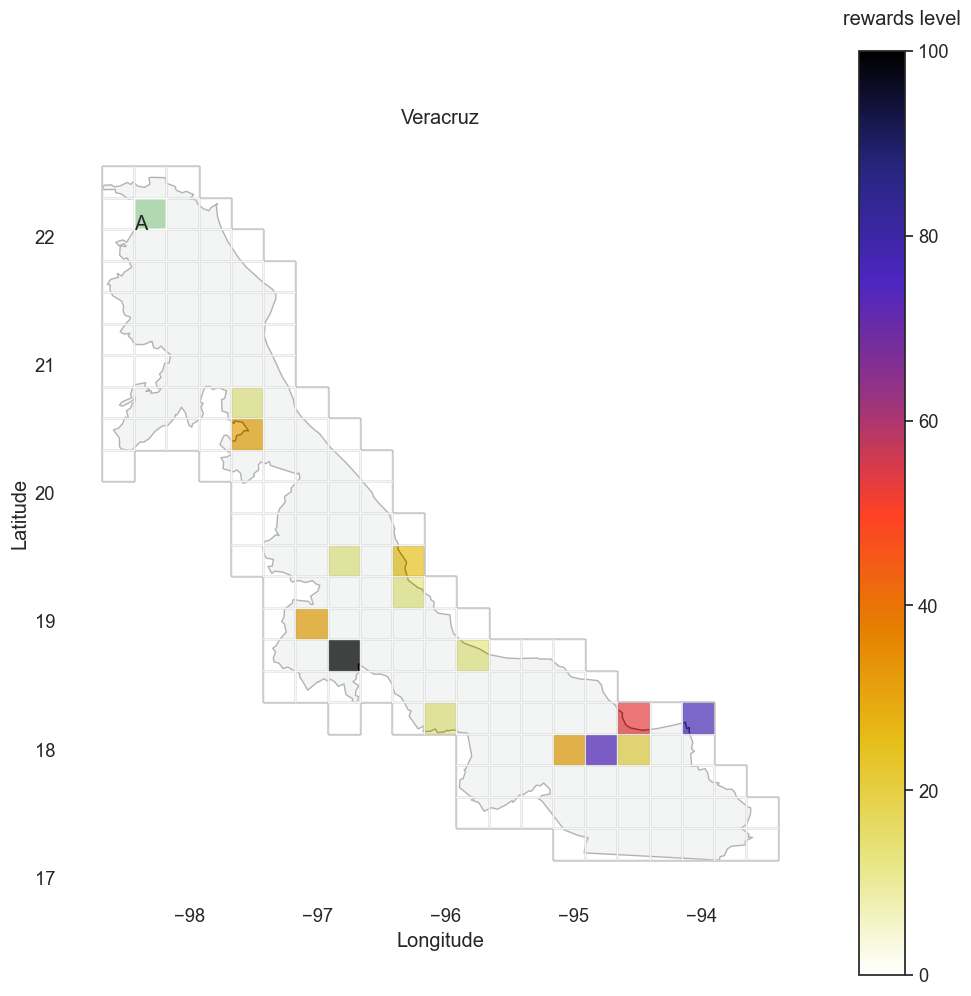

In [180]:
from shapely.geometry import Point

def plot_episode(episode,state,show=False):
    cell = grid.iloc[-state]['geometry']
    cell_geom = cell
    cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom])
    cell_coords=[(pt) for pt in list(cell.exterior.coords)]

    ax = geo_slice.plot(color='#d5deda', edgecolor='black', figsize=(12,12))

    sns.set_style("white")
    sns.despine(left=True, bottom=True)
    sns.set_context("notebook", font_scale=1.2)

    grid.plot(ax=ax, color='none', edgecolor='black')
    cell_gdf.plot(ax=ax, color='green',alpha=1)
    
    data = grid[['geometry', 'total_rewards']]
    data.plot(column='total_rewards', cmap='CMRmap_r', legend=True, ax=ax, alpha=0.7)
    ax.set(xlabel ="Longitude", ylabel = "Latitude", title ='Veracruz')
    plt.text(1.2, 1.16, 'rewards level', ha='right', va='top', transform=ax.transAxes)

    plt.annotate('A', xy=cell_coords[0])
    plt.savefig("episode"+str(episode)+".png")
    #if show:
        #plt.show()

plot_episode(1,6,show=False)